In [ ]:
import sys
import os
import time
sys.path.append('..')

In [2]:
from awsdet.utils.misc.config import Config
from awsdet.utils.logger import get_root_logger
from awsdet.utils.runner.dist_utils import init_dist
from awsdet.datasets.data_generator import DataGenerator
from awsdet.datasets import build_dataset
from awsdet.datasets.loader.build_loader import build_dataloader
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
config_path = '/workspace/shared_workspace/deep-learning-models/configs/rpn/rpn_r50_fpn_1x_coco.py'
cfg = Config.fromfile(config_path)
timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime())
cfg.work_dir = os.path.join('./work_dirs',
                                os.path.splitext(os.path.basename(config_path))[0])
log_file = os.path.join(cfg.work_dir, f'{timestamp}.log')

In [4]:
import matplotlib.patches as patches

def get_original_image(img_instance):
    img = (img_instance['img'] * \
       img_instance['img_metas']['img_norm_cfg']['std'] + \
       img_instance['img_metas']['img_norm_cfg']['mean'])/255.
    #img = img[:img_instance['img_metas']['img_shape'][0], :img_instance['img_metas']['img_shape'][1], :]
    return img

def show_box(img_instance, box_index=0):
    img = get_original_image(img_instance)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)
    bbox = img_instance['gt_bboxes'][box_index]
    y1 = bbox[1]
    x1 = bbox[0]
    h = bbox[3] - bbox[1]
    w = bbox[2] - bbox[0]
    rect = patches.Rectangle((y1,x1),h,w,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [5]:
init_dist()

In [6]:
#logger = get_root_logger(log_file=log_file, log_level=cfg.log_level)

In [7]:
coco = build_dataset(cfg.data.train)

loading annotations into memory...
Done (t=17.18s)
creating index...
index created!


In [8]:
train_tdf, train_size = build_dataloader(coco, 2)
train_tdf_iter = iter(train_tdf)

In [9]:
cfg.model.backbone

{'type': 'KerasBackbone',
 'model_name': 'ResNet50V1',
 'weights_path': None,
 'weight_decay': 0.0001}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


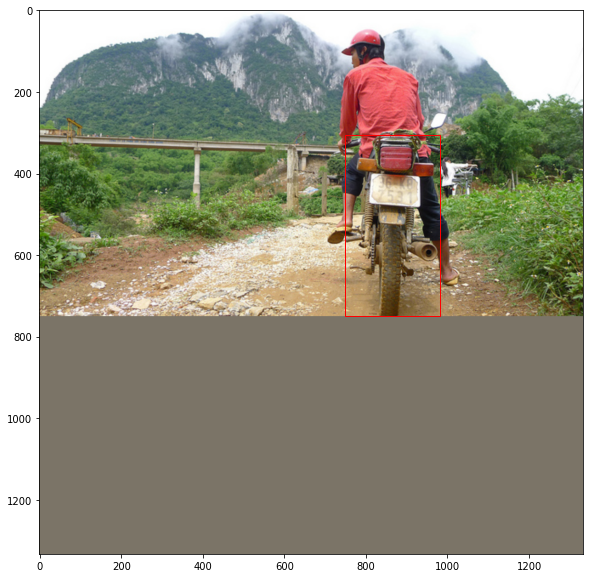

In [10]:
show_box(coco[0])

In [11]:
from awsdet.models.builder import build_backbone, build_neck

In [12]:
from awsdet.core.anchor.builder import build_anchor_generator
from awsdet.core.bbox.builder import build_assigner

In [13]:
#from awsdet.core.bbox.iou_calculators.iou2d_calculator import compute_overlaps
#from awsdet.utils.misc.meta import trim_zeros, calc_img_shapes
#from awsdet.core.bbox.assigners.assign_result

In [14]:
backbone = build_backbone(cfg.model.backbone)
neck = build_neck(cfg.model.neck)

In [15]:
imgs, img_metas, gt_bboxes = next(train_tdf_iter)
C2, C3, C4, C5 = backbone(imgs)
P2, P3, P4, P5, P6 = neck((C2, C3, C4, C5))

Starting new loop for GPU: 0


In [16]:
anchor_generator = build_anchor_generator(cfg.model.rpn_head.anchor_generator)

In [17]:
rpn_feature_maps = [P2, P3, P4, P5, P6]

In [18]:
featmap_sizes = [tf.shape(i)[1:3] for i in rpn_feature_maps]
num_imgs = len(img_metas)
multi_level_anchors = anchor_generator.grid_anchors(featmap_sizes)
anchor_list = [multi_level_anchors for _ in range(num_imgs)]

In [19]:
assigner_dict = {'type': 'MaxIoUAssigner',
                 'pos_iou_thr': 0.7,
                 'neg_iou_thr': 0.3}
assigner = build_assigner(assigner_dict)

In [21]:
result = assigner.assign(anchor_list[0], gt_bboxes[0])

In [24]:
pos_anchors = tf.squeeze(tf.gather(tf.concat(anchor_list[0], axis=0), tf.where(result.gt_inds>0)))

In [25]:
import matplotlib.patches as patches

def get_original_image(img):
    img = (img * \
       [58.395, 57.12 , 57.375] + \
       [123.675, 116.28 , 103.53 ])/255.
    #img = img[:img_instance['img_metas']['img_shape'][0], :img_instance['img_metas']['img_shape'][1], :]
    return img

def show_box(img, bbox):
    img = get_original_image(img)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)
    y1 = bbox[1]
    x1 = bbox[0]
    h = bbox[3] - bbox[1]
    w = bbox[2] - bbox[0]
    rect = patches.Rectangle((y1,x1),h,w,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


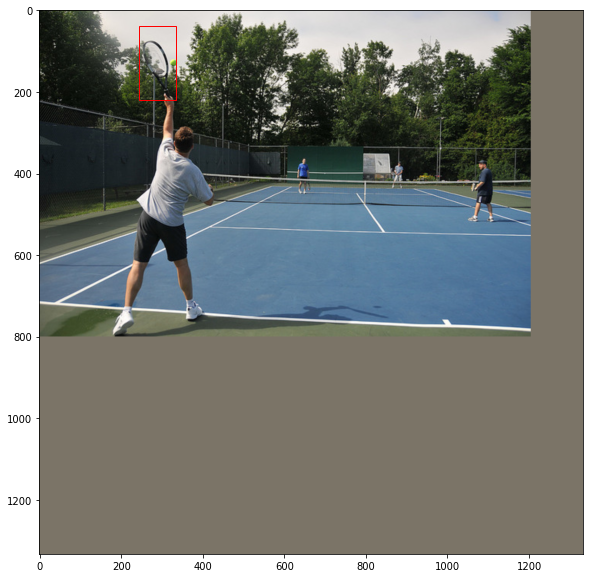

In [26]:
show_box(imgs[0], pos_anchors[6])

In [133]:
coco[0]

{'img_metas': {'filename': '/workspace/shared_workspace/data/coco/coco/train2017/000000391895.jpg',
  'ori_filename': '000000391895.jpg',
  'ori_shape': (360, 640, 3),
  'img_shape': (750, 1333, 3),
  'pad_shape': (1333, 1333, 3),
  'scale_factor': array([2.0828125, 2.0833333, 2.0828125, 2.0833333], dtype=float32),
  'flip': True,
  'flip_direction': 'horizontal',
  'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32),
   'std': array([58.395, 57.12 , 57.375], dtype=float32),
   'to_rgb': True}},
 'img': <tf.Tensor: shape=(1333, 1333, 3), dtype=float32, numpy=
 array([[[2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         ...,
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ]],
 
        [[2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ],
         [2.2489083, 2.4285715, 2.64     ]